# The forward and backward pass

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, matplotlib.pyplot as plt, numpy as np
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

In [ ]:
path = Path('data')
path_gz = path/'mnist.pkl.gz'
with gzip.open(path_gz) as f: (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding="latin-1")

# cast numpy arrays to torch tensors
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# Foundations version

## Basic architecture

We have 50 000 images each consisting of 784 pixels of 10 digits (from 0 to 9). 

In [ ]:
n,m = x_train.shape # examples, image_length
c = y_train.max() + 1 # num of classes
n,m,c

(50000, 784, tensor(10))

We set number of hidden units at 50 and initialize weights and biases for two layers.

In [ ]:
# number of hidden layers
nh = 50

In [ ]:
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)
b2 = torch.zeros(1)

In [ ]:
def lin(x, w, b): return x @ w + b

In [ ]:
t = lin(x_valid, w1, b1)
t.shape

torch.Size([10000, 50])

In [ ]:
def relu(x): return x.clamp_min(0.)

In [ ]:
t = relu(t)
t

tensor([[ 0.00, 11.87,  0.00,  ...,  5.48,  2.14, 15.30],
        [ 5.38, 10.21,  0.00,  ...,  0.88,  0.08, 20.23],
        [ 3.31,  0.12,  3.10,  ..., 16.89,  0.00, 24.74],
        ...,
        [ 4.01, 10.35,  0.00,  ...,  0.23,  0.00, 18.28],
        [10.62,  0.00, 10.72,  ...,  0.00,  0.00, 18.23],
        [ 2.84,  0.00,  1.43,  ...,  0.00,  5.75,  2.12]])

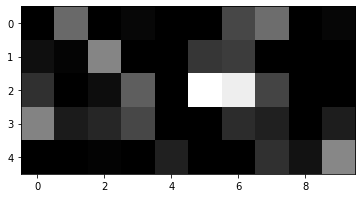

In [ ]:
plt.imshow(t[0].reshape(5,10));

We can combine the above functions in a simple method below.

In [ ]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    return lin(l2, w2, b2)

In [ ]:
res = model(x_valid)
res.shape

torch.Size([10000, 1])

Note that our final layers has a singe output which means that we cannot use the usual cross-entropy loss. For the sake of simplicity and demonstration we will use MSE loss and treat the final output as representing the particular digit.

## Loss function: MSE

In [ ]:
res.shape, y_valid.shape

(torch.Size([10000, 1]), torch.Size([10000]))

In [ ]:
(res-y_valid).shape

torch.Size([10000, 10000])

We can't simply subtract `res` from `y_valid` as due to the broadcasting rules we will get back (1000,1000) array! We need to remove the trailing unit dimension from `res`

In [ ]:
(res.squeeze(-1)-y_valid).shape

torch.Size([10000])

In [ ]:
y_train, y_valid = y_train.float(), y_valid.float()

preds = model(x_train)
preds.shape

torch.Size([50000, 1])

In [ ]:
def mse(output, targ): return ((output.squeeze()-targ)**2).mean()

In [ ]:
mse(preds, y_train)

tensor(4308.76)

## Gradients and backward pass

pytorch has a built-in automatic differentiation engine and we don't need to worry about calculating derivatives by hand. If you forget a particular derivative, you can use `sumpy` to remind yourself.

In [ ]:
from sympy import symbols, diff, sin
x,y = symbols('x y')
diff(x**2, x)

2*x

In [ ]:
diff(sin(3*x**2+9), x)

6*x*cos(3*x**2 + 9)

Below we caluclate the gradients by hand as a useful exercise. Note, that as our loss is a single number (a scalar), the shape of all our gradients of loss w.r.t a varaible will be the same shape as the variable itself. We will use this fact extensively to arrange the shapes correctly.

In [ ]:
def lin_grad(inp, out, w, b):
    # grad of matmul w.r.t input
    inp.g = out.g @ w.T
    w.g = inp.T @ out.g # 784, 50
    b.g = out.g.sum(dim=0)

In [ ]:
def forward_and_backward(inp, targ):
    # forward pass
    l1 = lin(inp, w1, b1)
    l2 = relu(l1)
    out = lin(l2, w2, b2)
    diff = out.squeeze(-1) - targ
    loss = (diff**2).mean()
    
    # backward pass
    # import ipdb; ipdb.set_trace()
    out.g = 2 * diff[:, None] / diff.shape[0] # dout
    lin_grad(l2, out, w2, b2)
    l1.g = l2.g * (l1>0).float()
    lin_grad(inp, l1, w1, b1)

In [ ]:
forward_and_backward(x_train, y_train)

In [ ]:
# to check our results
def get_grad(x): return x.g.clone()
chks = w1, w2, b1, b2, x_train
grads = w1g, w2g, b1g, b2g, ig = tuple(map(get_grad, chks))

We can check our manually calculated gradients against pytorch

In [ ]:
def mkgrad(x): return x.clone().requires_grad_(True)
ptgrads = w1pt, w2pt, b1pt, b2pt, x_trainpt = tuple(map(mkgrad, chks))

In [ ]:
def forward(inp, targ):
    # forward pass
    l1 = lin(inp, w1pt, b1pt)
    l2 = relu(l1)
    out = lin(l2, w2pt, b2pt)
    return mse(out, targ)

In [ ]:
loss = forward(x_trainpt, y_train)
loss.backward()

In [ ]:
loss

tensor(4308.76, grad_fn=<MeanBackward0>)

In [ ]:
for a,b in zip(grads, ptgrads): test_close(a, b.grad, eps=0.01)

## Refactor model

### Layers as classes

The above approach works but is a bit clunky and not flexible. We can refactor it using layers as classes. Note that for each layer we create the `inp` and `out` variables that are used during the backpropagation.

In [ ]:
class Relu:
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)
        return self.out
    def backward(self):
        # the gradient flows backwards through the calculation graph
        self.inp.g = self.out.g * (self.inp>0).float()

In [ ]:
class Lin:
    def __init__(self, w, b): self.w, self.b = w, b
    
    def __call__(self, inp):
        self.inp = inp
        self.out = lin(inp, self.w, self.b)
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.T
        self.w.g = self.inp.T @ self.out.g 
        self.b.g = self.out.g.sum(0)

Using ipdb tool we can check the shapes in the Mse backward function: `self.inp` is [5000, 1] while self.targ is [5000]. To avoid broadcasting the subtraction operation to [5000, 5000] we first squeeze the last dimension of `self.inp` and then unsueeze it back after the subtraction oepration.

![alt text](Screenshot.png)

In [ ]:
class Mse:
    def __call__(self, inp, targ):
        self.inp, self.targ = inp, targ
        self.out = mse(inp, targ)
        return self.out
    
    def backward(self):
        self.inp.g = 2.0 * ((self.inp.squeeze() - self.targ)).unsqueeze(-1) / self.targ.shape[0]

In [ ]:
class Model:
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for layer in self.layers: x = layer(x)
        return self.loss(x, targ)
    
    def backward(self):
        # import ipdb; ipdb.set_trace()
        self.loss.backward()
        for layer in self.layers[::-1]: layer.backward()

Let's test it out

In [ ]:
model = Model(w1, b1, w2, b2)

In [ ]:
loss = model(x_train, y_train)
loss

tensor(4308.76)

In [ ]:
model.backward()

In [ ]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

### Module.forward() 

We have a lot of code repetion here: each class initializes `inp`, `out`, and calls `forward` anb `backward` methods. We can incapsulate that functonality inside separate class Module and inherit from it.

In [ ]:
class Module:
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)
    def bwd(self): raise Exception('not implemented')

In [ ]:
class Relu(Module):
    def forward(self, inp): 
        
        return inp.clamp_min(0.)
    def bwd(self, out, inp): inp.g = out.g * (inp > 0.0).float()

In [ ]:
class Lin(Module):
    def __init__(self, w, b): self.w, self.b = w, b
    def forward(self, inp): return inp @ self.w + self.b
    def bwd(self, out, inp): 
        inp.g = out.g @ self.w.T
        self.w.g = inp.T @ out.g
        self.b.g = out.g.sum(0)

In [ ]:
class Mse(Module):
    def forward(self, inp, targ): return ((inp.squeeze() - targ)**2).mean()
    def bwd(self, out, inp, targ):
        inp.g = 2 * (inp.squeeze() - targ).unsqueeze(-1) / targ.shape[0]

In [ ]:
model = Model(w1, b1, w2, b2)

In [ ]:
loss = model(x_train, y_train)
loss

tensor(4308.76)

In [ ]:
model.backward()

In [ ]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

### Autograd 

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
class Linear(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn((n_in, n_out)).requires_grad_()
        self.b = torch.zeros(n_out).requires_grad_()
    
    def forward(self, inp): return inp @ self.w + self.b

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [Linear(n_in,nh), nn.ReLU(), Linear(nh, n_out)]
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return F.mse_loss(x, targ[:, None]) # add single dimension to targ for broadcasting

In [ ]:
model = Model(m, nh, 1)
loss = model(x_train, y_train)
loss.backward()

In [ ]:
l0 = model.layers[0]
l0.b.grad

tensor([ -31.94,  -12.18,  -64.23,   -8.61,   -5.96,   97.20,  -12.61,  -89.79,  -58.79, -106.23,  -13.70,  191.93,  -16.12,
         119.49,   -0.59,  103.04,   40.74,   97.59,   28.62,  -82.14,    2.68,  -37.39,  -93.23,  -34.24,   -4.76,   15.59,
          11.83,   -7.10,  -74.59,   13.74,   -1.70,   14.05,   79.34,   85.69,   19.94,   19.70,  105.85,   57.62,    4.06,
          22.64,  143.91,  116.68, -113.00,    4.70,  -52.45,  115.07,   36.34,  101.75,    3.77,   -2.66])